In [1]:
import sys
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np

try:
    if not(changed):
        raise Exception()
except:
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

%load_ext autoreload
%autoreload 2

In [2]:
from notebooks.notebooks_utils import get_activation, load_checkpoint

job_id = "4344494" # faenet

trainer = load_checkpoint(job_id)
train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/4344494/checkpoints/checkpoint-0021588.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channel

In [3]:
from notebooks.notebooks_utils import oc20_to_graph, plot_element_3d, process_datapoint

In [4]:
from ocpmodels.modules.evaluator import Evaluator
import seaborn as sns

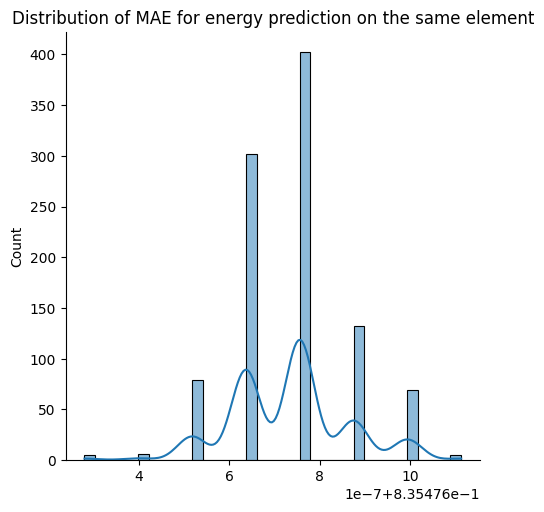

In [5]:
val_loader = trainer.get_dataloader(trainer.datasets["val_id"], trainer.samplers["val_id"])
trainer.model.eval()
evaluator = Evaluator(
    task=trainer.task_name,
    model_regresses_forces="",
)

batch = next(iter(val_loader))
maes = []
for _ in range(1000):
    with torch.cuda.amp.autocast(enabled=trainer.scaler is not None):
        preds = energy_prediction = trainer.model_forward(batch, mode="val")
    metrics = trainer.compute_metrics(preds, batch, evaluator, metrics={})
    maes.append(metrics["energy_mae"]["metric"])
sns.displot(maes, kde=True)
plt.title("Distribution of MAE for energy prediction on the same element")
plt.show()

In [6]:
import os
import pickle

In [7]:
directory = "/network/scratch/s/schmidtv/ocp/datasets/ocp/per_ads/oc20_data_mapping.pkl"
metadata = pickle.load(open(directory, "rb"))

In [8]:
# val_metrics = trainer.validate("val_id", disable_tqdm=False)

MAE: 0.02512204647064209: 100%|██████████| 24943/24943 [11:54<00:00, 34.89it/s]   


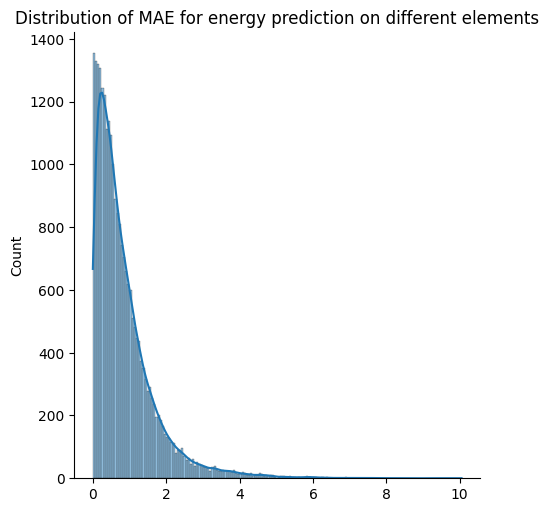

In [9]:
from collections import defaultdict
from tqdm import tqdm
import networkx as nx

pbar = tqdm(total=len(val_loader))
scores = defaultdict(list)
mispredicted_elements = []
mispredicted_indices = [] 

for i, batch in enumerate(val_loader):
    with torch.cuda.amp.autocast(enabled=trainer.scaler is not None):
        preds = energy_prediction = trainer.model_forward(batch, mode="val")
    metrics = trainer.compute_metrics(preds, batch, evaluator, metrics={})
    mae = metrics["energy_mae"]["metric"]
    scores["mae"].append(mae)
    pbar.set_description(f"MAE: {mae}")
    pbar.update(1)
    pbar.refresh()

    data_graph = oc20_to_graph(batch[0], processed=False)
    try:
        scores["diameter"].append(nx.diameter(data_graph))
    except:
        scores["diameter"].append(0)
    scores["connected"].append(nx.is_connected(data_graph))
    scores["number_of_nodes"].append(data_graph.number_of_nodes())
    scores["number_of_edges"].append(data_graph.number_of_edges())
    scores["edges/nodes"].append(data_graph.number_of_edges() / data_graph.number_of_nodes())
    # scores["density"].append(nx.density(data_graph))
    scores["target"].append(batch[0].y_relaxed.cpu().numpy()[0])
    scores["n_surface"].append((batch[0].tags.cpu().numpy() == 1).sum())
    scores["n_adsorbate"].append((batch[0].tags.cpu().numpy() == 2).sum())
    scores["y_init"].append(batch[0].y_init.cpu().numpy()[0])
    scores["average_degree"].append(np.mean(list(dict(data_graph.degree()).values())))
    scores["ads_symbols"].append(metadata[f"random{batch[0].sid.cpu().numpy()[0]}"]["ads_symbols"])
    scores["ads_id"].append(metadata[f"random{batch[0].sid.cpu().numpy()[0]}"]["ads_id"])
    scores["anomaly"].append(metadata[f"random{batch[0].sid.cpu().numpy()[0]}"]["anomaly"])
    scores["bulk_symbols"].append(metadata[f"random{batch[0].sid.cpu().numpy()[0]}"]["bulk_symbols"])
    scores["bulk_id"].append(metadata[f"random{batch[0].sid.cpu().numpy()[0]}"]["bulk_id"])
    scores["shift"].append(metadata[f"random{batch[0].sid.cpu().numpy()[0]}"]["shift"])


    if mae > 10:
        mispredicted_elements.append(batch[0])
        mispredicted_indices.append(i)


pbar.close()
sns.displot(scores["mae"], kde=True)
plt.title("Distribution of MAE for energy prediction on different elements")
plt.show()

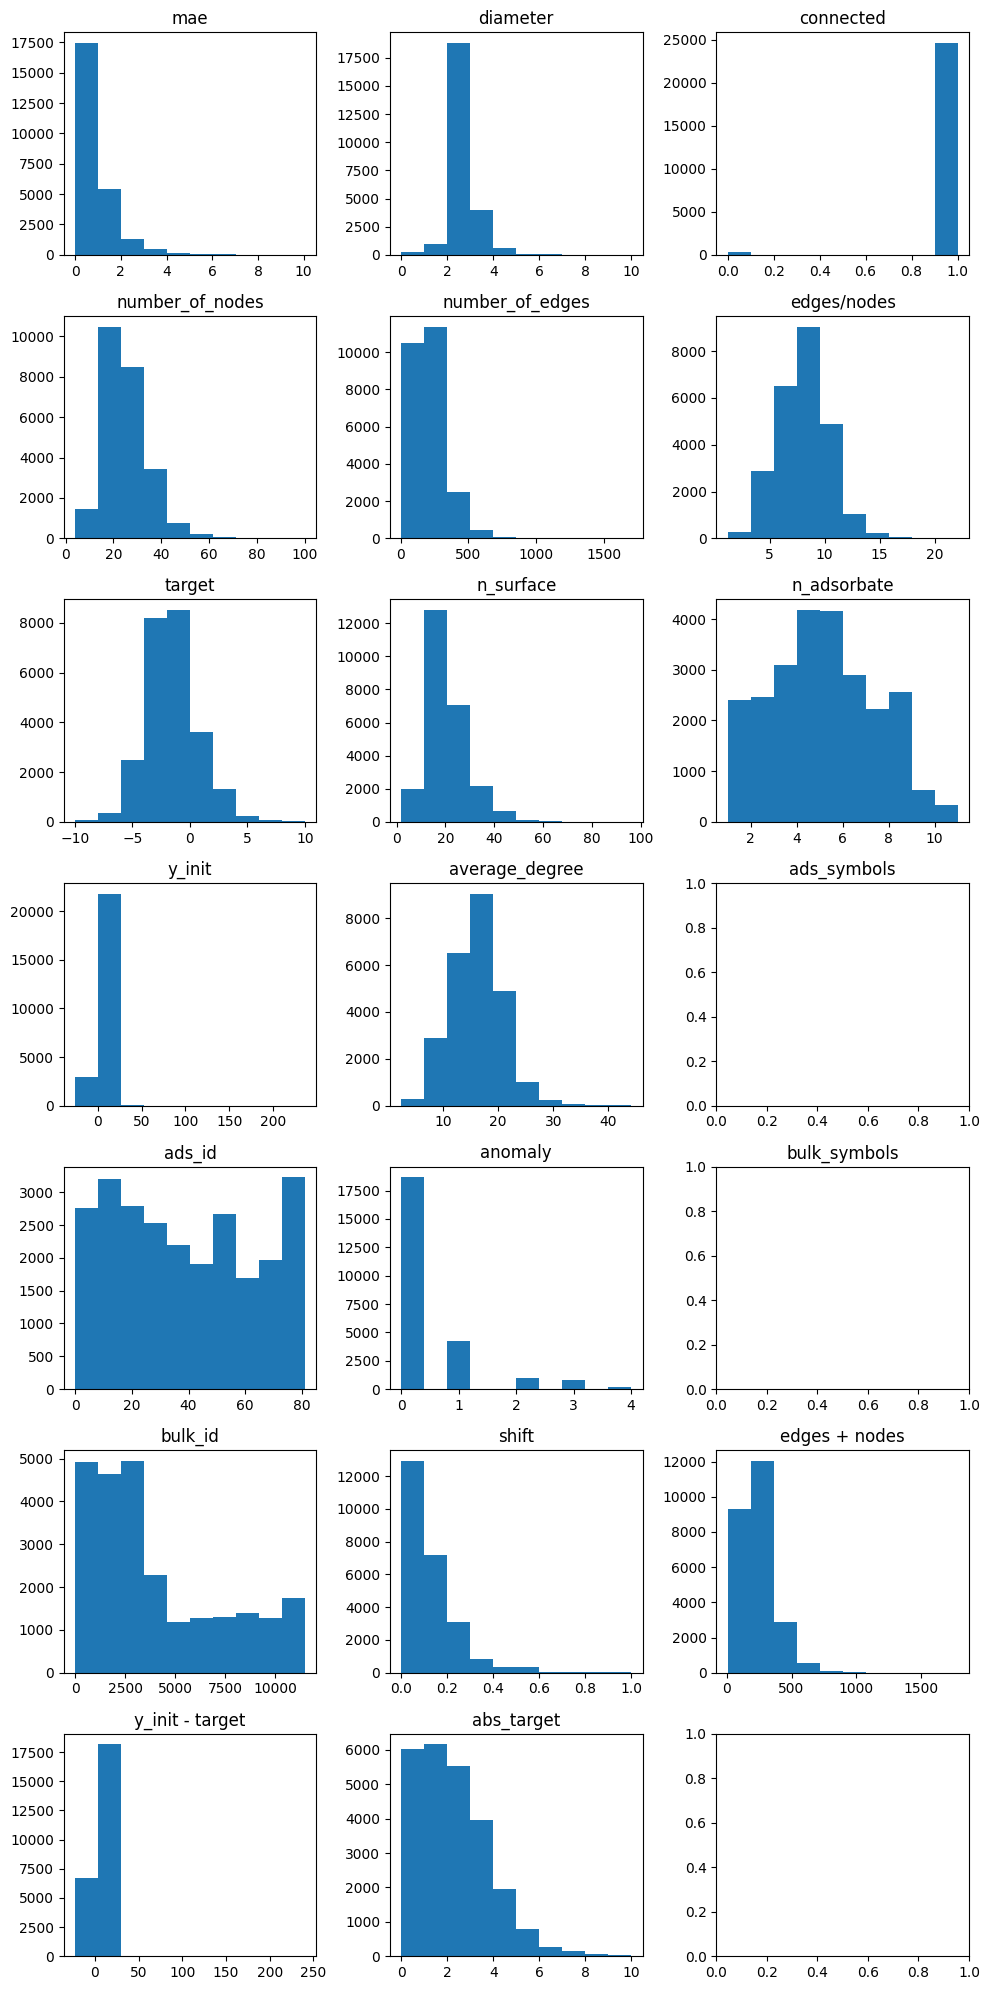

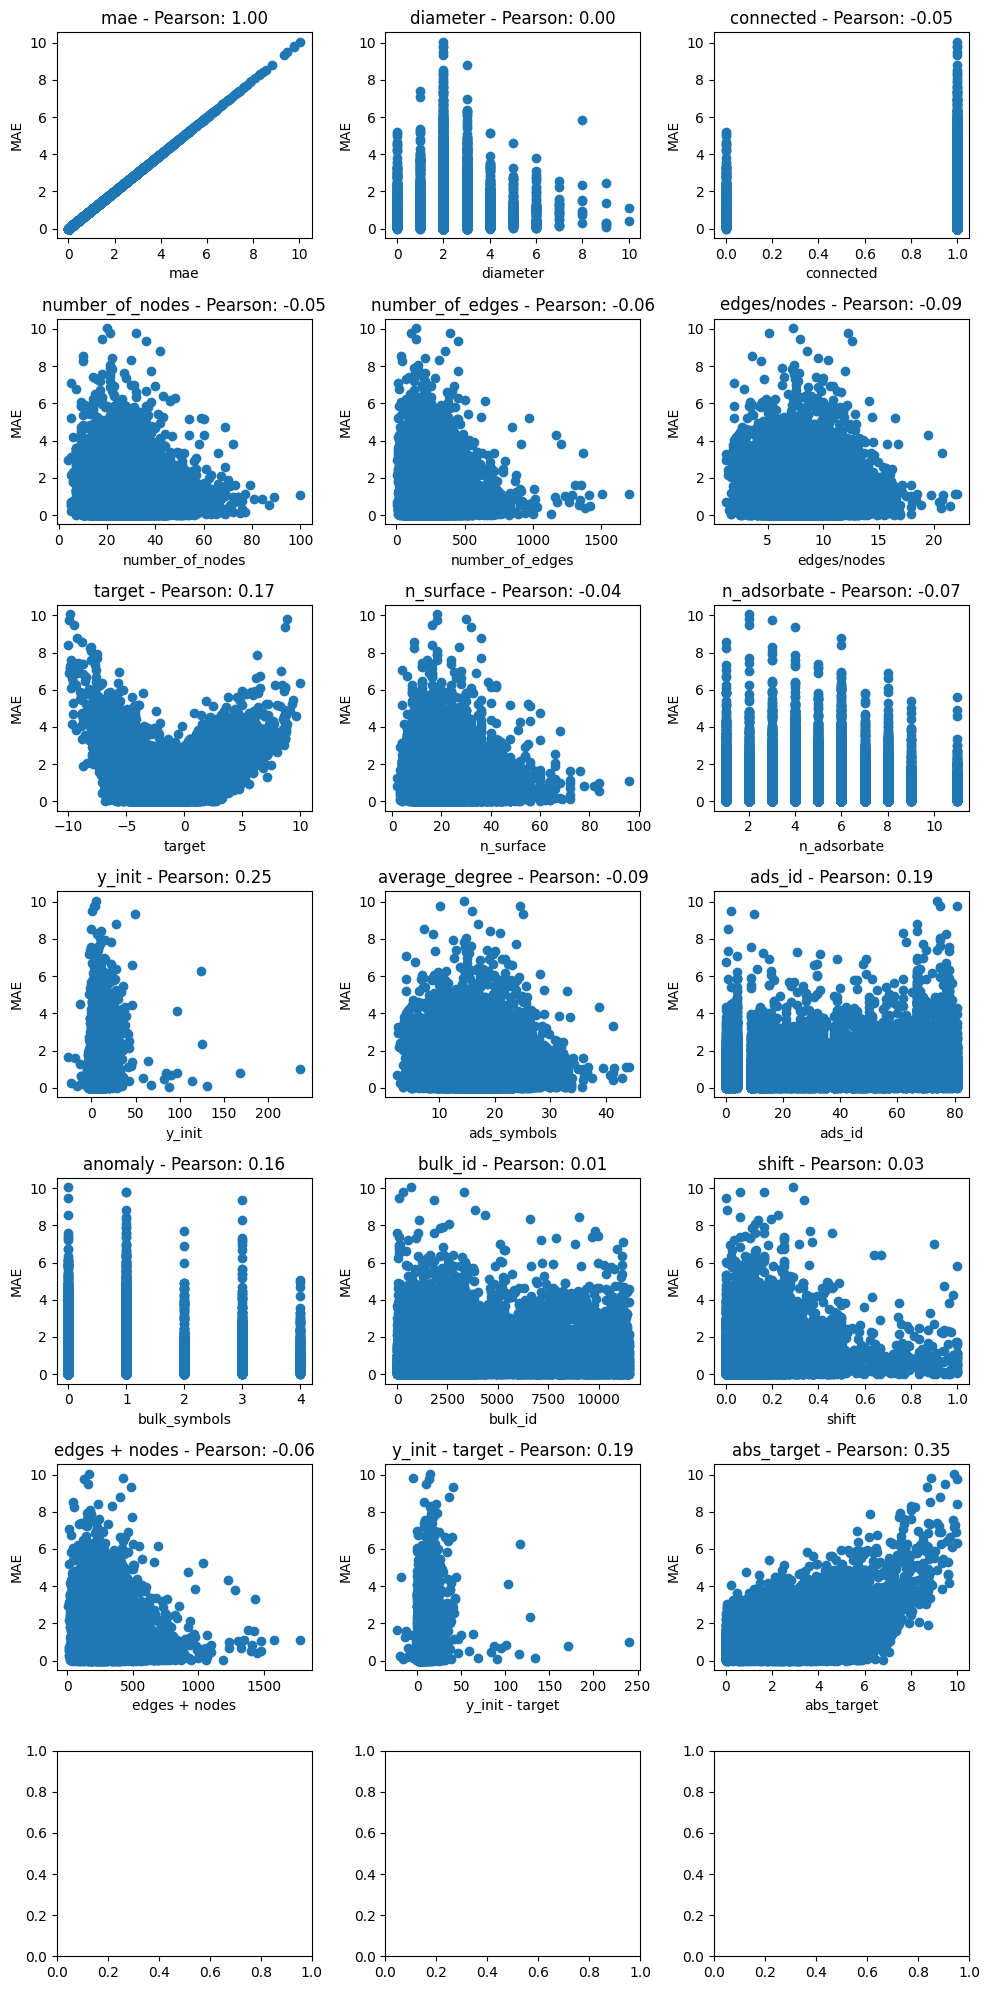

In [21]:
n = 7

fig, axes = plt.subplots(n, 3, figsize=(10, 20))

scores["edges + nodes"] = np.array(scores["number_of_edges"]) + np.array(scores["number_of_nodes"])
scores['y_init - target'] = np.array(scores["y_init"]) - np.array(scores["target"])
scores["abs_target"] = np.abs(np.array(scores["target"]))
scores["connected"] = np.array(scores["connected"]).astype(int)

for i, key in enumerate(scores.keys()):
    ax = axes[i // 3, i % 3]
    if key not in [] and "symbol" not in key:
        ax.hist(scores[key])
    ax.set_title(key)

fig.tight_layout()
plt.show()

fig, axes = plt.subplots(n, 3, figsize=(10, 20))

i = -1
for key in scores.keys():
    if key not in [] and "symbol" not in key:
        i += 1
        ax = axes[i // 3, i % 3]
        ax.plot(scores[key], scores["mae"], "o")
        ax.set_title(f"{key} - Pearson: {np.corrcoef(scores[key], scores['mae'])[0, 1]:.2f}")
    ax.set_ylabel("MAE")
    ax.set_xlabel(key)

fig.tight_layout()
plt.show()

In [15]:
print(f"Percentage of non connected graphs: {100 - np.mean(scores['connected'])*100}%")

Percentage of non connected graphs: 1.1546325622419147%


Linear regression: MAE: 0.50, MSE: 0.48


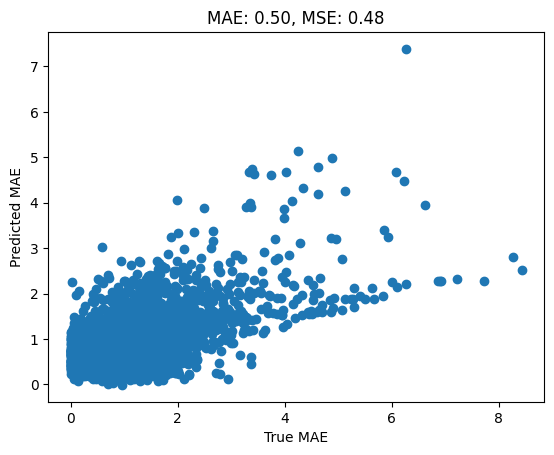

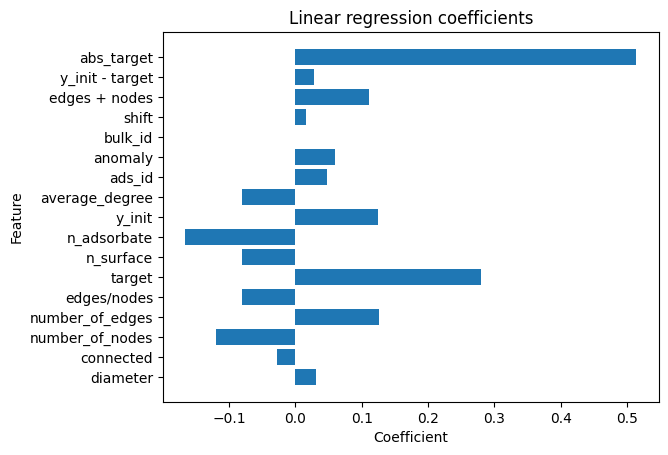

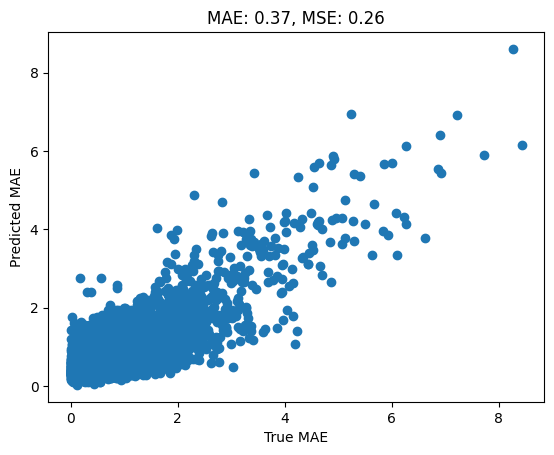

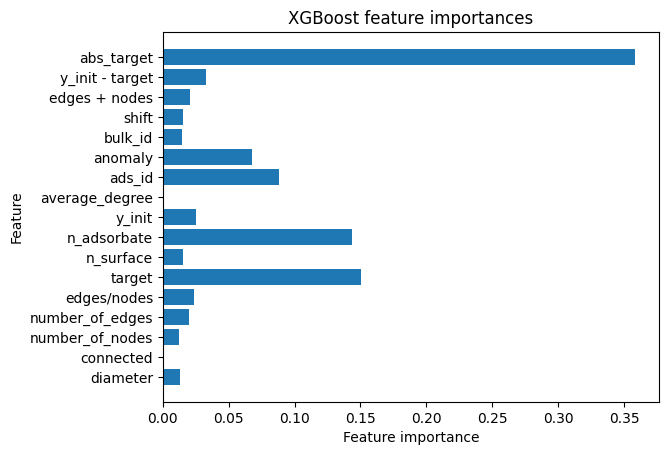

[(0.012688722, 'diameter'), (0.0, 'connected'), (0.0119380085, 'number_of_nodes'), (0.020025987, 'number_of_edges'), (0.023836635, 'edges/nodes'), (0.15060574, 'target'), (0.015064159, 'n_surface'), (0.14331831, 'n_adsorbate'), (0.025349528, 'y_init'), (0.0, 'average_degree'), (0.08839427, 'ads_id'), (0.0675642, 'anomaly'), (0.014351674, 'bulk_id'), (0.015338494, 'shift'), (0.020514907, 'edges + nodes'), (0.03263622, 'y_init - target'), (0.3583731, 'abs_target')]
[(0.031128378935210917, 'diameter'), (-0.02764275850146307, 'connected'), (-0.11908882206984817, 'number_of_nodes'), (0.12643619557967056, 'number_of_edges'), (-0.07988549275199493, 'edges/nodes'), (0.28005285728113766, 'target'), (-0.0804168522081596, 'n_surface'), (-0.16565228701225074, 'n_adsorbate'), (0.12398938691756926, 'y_init'), (-0.0798854839193397, 'average_degree'), (0.04794391815455198, 'ads_id'), (0.059382122422990694, 'anomaly'), (-6.88440713511051e-05, 'bulk_id'), (0.01676117923456863, 'shift'), (0.1105847633772

In [20]:
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

scores["mae"] = np.array(scores["mae"])

threshold = 0
linreg = Ridge(alpha=1e-3)
X_list = []
keys = []
for key in scores.keys():
    if key not in ["mae"] and "symbols" not in key:
    # if key not in ["mae", "y_init", "target", "y_init - target"] and "symbol" not in key:
        X_list.append(np.array(scores[key])[scores["mae"] > threshold].astype(float))
        keys.append(key)

X = np.stack(X_list, axis=1)
y = scores["mae"][scores["mae"] > threshold]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred_tree = xgb_reg.predict(X_test)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Linear regression: MAE: {mae:.2f}, MSE: {mse:.2f}")

plt.plot(y_test, y_pred, "o")
plt.xlabel("True MAE")
plt.ylabel("Predicted MAE")
plt.title(f"MAE: {mae:.2f}, MSE: {mse:.2f}")
plt.show()

plt.barh(keys, linreg.coef_)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Linear regression coefficients")
plt.show()


plt.plot(y_test, y_pred_tree, "o")
plt.xlabel("True MAE")
plt.ylabel("Predicted MAE")
plt.title(f"MAE: {mae_tree:.2f}, MSE: {mse_tree:.2f}")
plt.show()

plt.barh(keys, xgb_reg.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("XGBoost feature importances")
plt.show()
print(list(zip(xgb_reg.feature_importances_, keys)))

print(list(zip(linreg.coef_, keys)), linreg.intercept_)

In [ ]:
# box plot of mae on different bulk_id

keys = ["bulk_id", "ads_id"]
symbols_keys = ["bulk_symbols", "ads_symbols"]

for key, symbols_key in zip(keys, symbols_keys):
    n_bulks = min(80, len(np.unique(scores[key])))
    bulk_ids = np.array(scores[key])
    bulk_symbols = np.array(scores[symbols_key])
    unique_bulk_ids = np.unique(bulk_ids)[:n_bulks]
    bulk_ids_index = np.zeros_like(bulk_ids).astype(bool)
    bulk_symbols_plot = np.zeros(n_bulks).astype(str)
    for i, bulk_id in enumerate(unique_bulk_ids):
        bulk_ids_index[bulk_ids == bulk_id] = True
        bulk_symbols_plot[i] = bulk_symbols[bulk_ids == bulk_id][0]
    bulk_ids_plot = np.array(bulk_ids)[bulk_ids_index]
    maes = np.array(scores["mae"])[bulk_ids_index]

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.boxplot([maes[bulk_ids_plot == bulk_id] for bulk_id in unique_bulk_ids])
    ax.set_xticklabels(bulk_symbols_plot)
    ax.set_title(f"MAE distribution for different {key}")
    ax.set_xlabel(key)
    ax.set_ylabel("MAE")
    plt.show()